# Predecir el Puntaje de Recencia en Papers de Investigación
*Notebook created by Erick Calderin*

**Web site:** https://www.datasource.ai/es/home/data-science-competitions-for-startups/predecir-el-puntaje-de-recencia-en-papers-de-investigacion

## Modules

In [1]:
# Utilities

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# For ML
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
import multiprocessing as mp

For NLP

In [4]:
# Install
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
!python -m spacy download pt_core_news_sm

  Attempting uninstall: spacy
    Found existing installation: spacy 3.1.1
    Uninstalling spacy-3.1.1:
      Successfully uninstalled spacy-3.1.1


You should consider upgrading via the 'c:\users\erick\anaconda3\python.exe -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-08-31 01:37:03.303834: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
You should consider upgrading via the 'C:\Users\Erick\anaconda3\python.exe -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


2021-08-31 01:37:23.791077: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
You should consider upgrading via the 'C:\Users\Erick\anaconda3\python.exe -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


2021-08-31 01:37:36.335597: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
You should consider upgrading via the 'C:\Users\Erick\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
import spacy
import re
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

## Importing data

Getting training and test datasets from Drive.

In [4]:
# Train
#PREFIX = '/content/drive/MyDrive/Colab Notebooks/CompetenciaPuntajeRecencia'
#train = pd.read_csv(PREFIX+'/Train.csv')
#test = pd.read_csv(PREFIX+'/Test.csv')

train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

## Exploring

In [5]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score
0,1,en,2016,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682
1,2,en,2019,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333
2,3,en,2019,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222
3,4,en,2017,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765
4,5,en,2015,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737


In [6]:
print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (21456, 6)
Test Shape (10728, 5)


In [7]:
print('Unique languages\n', train.Language.value_counts())
print('\nAmount Unique Years', len(train.Year.value_counts()))

Unique languages
 en    18539
pt     1539
es     1378
Name: Language, dtype: int64

Amount Unique Years 59


No missing values!

In [8]:
train.isna().sum()

id                 0
Language           0
Year               0
Abstract           0
Title              0
total_rel_score    0
dtype: int64

Score distribution for each language

Text(0.5, 6.79999999999999, 'Scores')

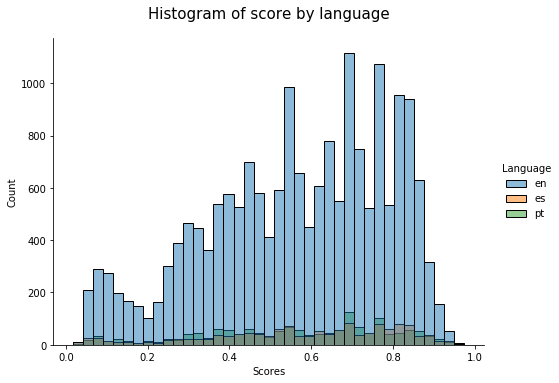

In [12]:
sns.displot(data=train, x= 'total_rel_score', aspect=1.4, hue='Language')
plt.title('Histogram of score by language', fontsize=15, pad=20)
plt.xlabel('Scores')

Plot above indicate us there is no outliers within data, another great new! However we can notice that papers at english language overcome to ones created in other languages.

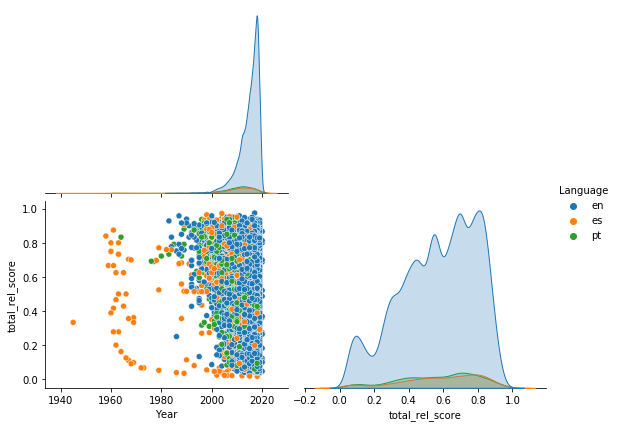

In [13]:
sns.pairplot(train.drop(columns=['id']), hue='Language', corner=True, aspect=1.3, height=3)

In another hand, there is a clear separation between papers at spanish language in early years and rest of papers.

## Preprocessing

### Creating dummy variables for Language

In [5]:
dummy_language = OneHotEncoder(dtype='int8')
df_dummy_language = dummy_language.fit_transform(train[['Language']]).toarray()

In [6]:
train = train.join(pd.DataFrame(df_dummy_language, columns=dummy_language.categories_[0]))

### MinMaxScaler to Year

In [7]:
minMaxScaler = MinMaxScaler()
year_minmax = minMaxScaler.fit_transform(train[['Year']])
train.Year = year_minmax

In [8]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score,en,es,pt
0,1,en,0.946667,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682,1,0,0
1,2,en,0.986667,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333,1,0,0
2,3,en,0.986667,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222,1,0,0
3,4,en,0.960000,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765,1,0,0
4,5,en,0.933333,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737,1,0,0


### Applying NLP

##### Tokenizing

In [9]:
# Loading spacy for every target language
nlp_en = spacy.load('en_core_web_sm')
nlp_es = spacy.load('es_core_news_sm')
nlp_pt = spacy.load('pt_core_news_sm')

stem_en = SnowballStemmer(language='english')
stem_es = SnowballStemmer(language='spanish')
stem_pt = SnowballStemmer(language='portuguese')

In [10]:
# Function for lemmatization, filtering stopword and length of words

def get_tokens(dataframe):
    '''
    dataframe: Pandas Dataframe with two columns 'Abstract' and 'Language'
    '''
    nlp_dict = {
        'en': [nlp_en, stem_en],
        'es': [nlp_es, stem_es],
        'pt': [nlp_pt, stem_pt]
    }
    tokens_doc = []
    pos_list = []
    for item in tqdm(dataframe.itertuples()):
        # Features
        abstract_title = item.abstract_title
        language = item.Language
        abstract = item.Abstract
        # Re
        text_re = re.sub('[^A-ZÜÖÄa-zá-ú]+', ' ', abstract_title).strip()
        nlp_spacy = nlp_dict.get(language)[0]        
        # Filtering 
        tokens = [word.lemma_ for word in nlp_spacy(text_re) 
                  if word.pos_ not in ['PUNCT', 'SPACE', 'NUM', 'DET']
                  and not word.is_stop
                ]
        nlp_nltk = nlp_dict.get(language)[1]
        tokens = [nlp_nltk.stem(token) for token in tokens]
        tokens = [token for token in tokens if len(token)>3]
        tokens_doc.append(' '.join(tokens))
        
        # Getting tag position
        pos = [word.pos_ for word in nlp_spacy(abstract)]
        pos_list.append(' '.join(pos))
    return tokens_doc, pos_list

In [12]:
# Concatenating Abstract and Title

train['abstract_title'] = train.Abstract + ' ' + train.Title

In [13]:
%%time
result_tokenization = get_tokens(train[['abstract_title', 'Abstract', 'Language']])


Wall time: 25min 50s


In [14]:
train['Abstract_tokens'] = result_tokenization[0]
train['pos_tokens'] = result_tokenization[1]

In [15]:
train[['Abstract', 'Abstract_tokens', 'pos_tokens', 'total_rel_score']].head()

,Abstract,Abstract_tokens,pos_tokens,total_rel_score
0,The present study investigates an inventory mo...,present studi investig inventori model instant...,DET ADJ NOUN VERB DET NOUN NOUN ADP ADJ ADJ AD...,0.630682
1,AIM: To investigate the clinical characteristi...,investig clinic characterist surgic treatment ...,PROPN PUNCT PART VERB DET ADJ NOUN CCONJ ADJ N...,0.583333
2,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...",aflatoxin ochratoxin wide coexist milk pose th...,PROPN PROPN PUNCT PROPN PUNCT CCONJ PROPN PROP...,0.372222
3,Background/Aim: There are still unrevealed tre...,background unreveal treasur tradit dental medi...,NOUN PUNCT PROPN PUNCT PRON AUX ADV VERB NOUN ...,0.661765
4,Impairment in empathy has been demonstrated in...,impair empathi demonstr patient schizophrenia ...,NOUN ADP NOUN AUX AUX VERB ADP NOUN ADP NOUN C...,0.373737


##### Vectorization

In [26]:
vectorizer_model = TfidfVectorizer(min_df=15, encoding='ascii', sublinear_tf=True)
vectorizer_values = vectorizer_model.fit_transform(train['Abstract_tokens'])

In [27]:
train_tfidf = train.join(pd.DataFrame(vectorizer_values.toarray(), 
                        columns=vectorizer_model.get_feature_names())
        )

In [18]:
tfidf_POS_model = TfidfVectorizer(sublinear_tf=True)
tfidf_POS_values = tfidf_POS_model.fit_transform(train['pos_tokens'])

In [28]:
train_tfidf = train_tfidf.join(pd.DataFrame(tfidf_POS_values.toarray(), 
                        columns=list(map(lambda x:'_'+x, tfidf_POS_model.get_feature_names())))
        )

In [29]:
print(train_tfidf.shape)

(21456, 8985)


### Dropping unnecessary columns:

In [30]:
COLS = ['id', 'Abstract', 'Title', 'Language', 'Abstract_tokens', 'pos_tokens', 'abstract_title']
train_tfidf.drop(COLS, axis=1, inplace=True)

In [31]:
train_tfidf.head()

,Year,total_rel_score,en,es,pt,aacut,abaix,abandon,abbrevi,abdoman,...,_noun,_num,_part,_pron,_propn,_punct,_sconj,_space,_sym,_verb
0,0.946667,0.630682,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.399522,0.000000,0.313849,0.152016,0.000000,0.307946,0.000000,0.181182,0.000000,0.322391
1,0.986667,0.583333,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.368929,0.288948,0.212450,0.227331,0.206804,0.320247,0.000000,0.000000,0.157759,0.276929
2,0.986667,0.372222,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.370883,0.152849,0.160024,0.181413,0.318057,0.314918,0.164068,0.000000,0.167476,0.290211
3,0.960000,0.661765,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.366876,0.318265,0.147178,0.134614,0.231244,0.321016,0.150898,0.160442,0.154032,0.273688
4,0.933333,0.373737,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.385220,0.306359,0.000000,0.181185,0.273705,0.339543,0.163862,0.000000,0.000000,0.277218


## Training

In [32]:
X = train_tfidf.drop('total_rel_score', axis=1)
y = train_tfidf.total_rel_score

In [33]:
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, shuffle=True)

In [34]:
%%time
model = BayesianRidge(verbose=True)
model.fit(X_train, y_train)

Convergence after  25  iterations
Wall time: 15min 2s


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=True)

In [35]:
def results_metric(model):
    # Predict for train and test
    y_pred_train = model.predict(X_train).flatten()
    y_pred_test = model.predict(X_test).flatten()

    # RMSLE metric
    rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
    rmsle_test = np.sqrt(mean_squared_log_error(y_test, y_pred_test))

    # Plotting results
    plt.figure(figsize=(12, 5))
    sns.set(color_codes=True)
    plt.subplot(1, 2, 1)    
    sns.histplot(y_train - y_pred_train, bins=20, kde=True, color='g')
    sns.histplot(y_test - y_pred_test, bins=20, kde=True, color='r')
    plt.legend(['Train','Test'])
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred_test)
    sns.set(None)
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  # min of both axes
        np.max([plt.xlim(), plt.ylim()]),  # max of both axes]
    ]

    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Y Test')
    plt.ylabel('Y Pred Test')
    print('RMSLE Train', rmsle_train)
    print('RMSLE Test', rmsle_test)

RMSLE Train 0.12372225608191549
RMSLE Test 0.1348380903600247


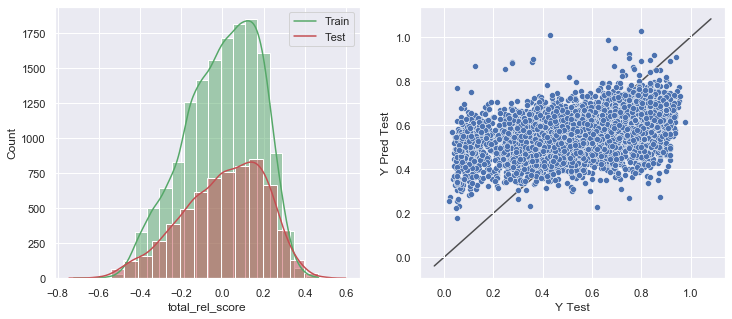

In [36]:
results_metric(model)

Training with all data:

In [37]:
%%time
full_model = BayesianRidge(verbose=True)
full_model.fit(X, y)

Convergence after  23  iterations
Wall time: 15min 53s


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=True)

## Predictions

Preprocessing Test dataset

In [38]:
# Creating dummy variables from OneHotEncoder created previosly...
dummy_test = dummy_language.transform(test[['Language']]).toarray()

# Converting to Dataframe with named columns for dummy
dummy_test = pd.DataFrame(dummy_test, columns=dummy_language.categories_[0])

# Scaling Year
test.Year = minMaxScaler.transform(test[['Year']])

# Joining dummy columns to full test dataset
test = test.join(dummy_test)

Saving Id column for submission csv file:

In [39]:
id = test.id

Applying NLP

In [40]:
test['abstract_title'] = test.Abstract + ' ' + test.Title

In [41]:
%%time
result_tokenization_test = get_tokens(test[['abstract_title', 'Abstract', 'Language']])


Wall time: 13min 9s


In [42]:
test['Abstract_tokens'] = result_tokenization_test[0]
test['pos_tokens'] = result_tokenization_test[1]

In [43]:
vectorizer_values_test = vectorizer_model.transform(test['Abstract_tokens'])
test_tfidf = test.join(pd.DataFrame(vectorizer_values_test.toarray(), 
                        columns=vectorizer_model.get_feature_names())
        )

In [44]:
tfidf_POS_values_test = tfidf_POS_model.fit_transform(test['pos_tokens'])
test_tfidf = test_tfidf.join(pd.DataFrame(tfidf_POS_values_test.toarray(), 
                        columns=list(map(lambda x:'_'+x, tfidf_POS_model.get_feature_names())))
        )

Removing same columns as train dataset:

In [45]:
test_tfidf.drop(COLS, axis=1, inplace=True)

In [46]:
test_tfidf.head()

,Year,en,es,pt,aacut,abaix,abandon,abbrevi,abdoman,abdomen,...,_noun,_num,_part,_pron,_propn,_punct,_sconj,_space,_sym,_verb
0,0.933333,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.343742,0.227546,0.091307,0.000000,0.127994,0.288743,0.000000,0.574347,0.0,0.252622
1,0.906667,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.402975,0.269479,0.263740,0.000000,0.218357,0.329610,0.000000,0.000000,0.0,0.300682
2,0.866667,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.420221,0.158610,0.098088,0.089628,0.250081,0.322854,0.099350,0.000000,0.0,0.304178
3,0.813333,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.367936,0.000000,0.000000,0.278081,0.458259,0.278288,0.110413,0.000000,0.0,0.301602
4,0.973333,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.408455,0.242442,0.190829,0.216813,0.075284,0.320189,0.193284,0.000000,0.0,0.317323


In [47]:
assert test_tfidf.shape[1] == train_tfidf.shape[1]-1, 'Number of input columns must be equal'

In [48]:
y_pred = full_model.predict(test_tfidf)
predictions = pd.DataFrame({'id':id, 'total_rel_score':y_pred})
predictions.head()

,id,total_rel_score
0,1,0.604005
1,2,0.579858
2,3,0.624943
3,4,0.545077
4,5,0.576362


In [49]:
predictions.to_csv('SampleSubmission.csv', index=False)